In [62]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
from galton import n_nails 
from galton import n_rows
theta_0 = -0.8
theta_1 = -0.6

# Density estimation with histograms

In [177]:
samples_0, _, scores_0, _ = galton_rvs(theta_0, n_runs=20000, random_state=1234)
p_estimated_0, _ = np.histogram(samples_0, bins=n_nails, range=(0, n_nails), density=True)

samples_1, _, scores_1, _ = galton_rvs(theta_1, n_runs=20000, random_state=1234)
p_estimated_1, _ = np.histogram(samples_1, bins=n_nails, range=(0, n_nails), density=True)

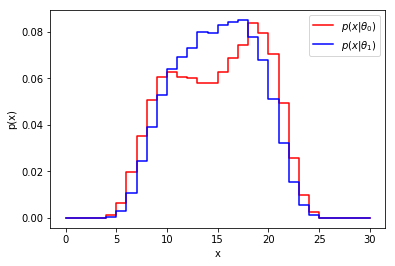

In [178]:
plt.step(range(len(p_estimated_0)), p_estimated_0,
         c='r', lw=1.5,
         label=r'$p(x|\theta_0)$')
plt.step(range(len(p_estimated_0)), p_estimated_1,
         c='b', lw=1.5, 
         label=r'$p(x|\theta_1)$')

plt.xlabel("x")
plt.ylabel("p(x)")
plt.legend()
plt.show()

/home/gilles/anaconda3/envs/simulator-mining-example/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


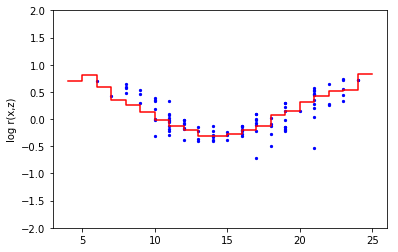

In [179]:
plt.step(range(len(p_estimated_0)), np.log(p_estimated_0/p_estimated_1),
         c='r', lw=1.5,
         label=r'$p(x|\theta_0)$')
plt.scatter(samples, np.array(log_p0) - np.array(log_p1), s=5., c='b')
plt.ylabel('log r(x,z)')
plt.ylim(-2.,2.)
plt.show()

# Training data

In [180]:
from galton import check_random_state

def draw(n_samples, n_thetas=10, random_state=0):
    n_traces_per_theta = n_samples 
    
    all_x = []
    all_t_xz = []
    all_thetas = []
    
    for k, theta in enumerate(np.linspace(-1.0, -0.4, n_thetas)):
        x, log_p_xz, t_xz, _ = galton_rvs(theta, n_runs=n_traces_per_theta, random_state=random_state+k)
        all_x.append(x)
        all_t_xz.append(t_xz)
        all_thetas.append(theta * np.ones(n_traces_per_theta))
        
    all_x = np.array(all_x).reshape(-1, 1)
    all_x = to_categorical(all_x, num_classes=n_nails)
    all_t_xz = np.array(all_t_xz).reshape(-1, 1)
    all_thetas = np.array(all_thetas).reshape(-1, 1)
    
    rng = check_random_state(random_state)
    choices = rng.choice(len(all_x), len(all_x), replace=False)
        
    return all_x[choices], all_t_xz[choices], all_thetas[choices]

In [181]:
x, t_xz, theta = draw(3000)

# NDE + SCANDAL

In [182]:
n_features = 1 
hidden_size = 10
n_outputs = n_nails

In [183]:
from keras.optimizers import Adam
from keras.layers import Input, Dense, Lambda, dot
from keras.models import Model
from keras.utils import to_categorical
import keras.backend as K

def make_nde(lr=0.001):   
    theta = Input(shape=(1,))
    h = Dense(hidden_size, activation="tanh")(theta)
    phat_theta = Dense(n_outputs, activation="softmax")(h)
    
    model = Model(inputs=[theta], outputs=[phat_theta])
    opt = Adam(lr=lr)
    model.compile(loss=["categorical_crossentropy"], optimizer=opt)
    
    return model

def make_scandal(lr=0.001):
    theta = Input(shape=(1,))
    h = Dense(hidden_size, activation="tanh")(theta)
    phat_theta = Dense(n_outputs, activation="softmax")(h)
    
    x = Input(shape=(n_outputs,))
    phat_x_theta = dot([x, phat_theta], axes=1) 
    t_x = Lambda(lambda exp: K.gradients(K.log(exp[0]), [exp[1]])[0], 
                 output_shape=(n_features,))([phat_x_theta, theta])
    
    model = Model(inputs=[theta, x], outputs=[phat_theta, t_x])
    opt = Adam(lr=lr)
    model.compile(loss=["categorical_crossentropy", "mse"], optimizer=opt)
    
    return model

In [184]:
nde = make_nde()
nde.fit(theta, x, batch_size=32, epochs=50)

Epoch 1/50
30000/30000 [==============================] - 3s 91us/step - loss: 2.9486
Epoch 2/50
30000/30000 [==============================] - 1s 46us/step - loss: 2.8250
Epoch 3/50
30000/30000 [==============================] - 1s 46us/step - loss: 2.8196
Epoch 4/50
30000/30000 [==============================] - 1s 47us/step - loss: 2.8169
Epoch 5/50
30000/30000 [==============================] - 1s 47us/step - loss: 2.8140
Epoch 6/50
30000/30000 [==============================] - 2s 50us/step - loss: 2.8099
Epoch 7/50
30000/30000 [==============================] - 2s 53us/step - loss: 2.8051
Epoch 8/50
30000/30000 [==============================] - 1s 48us/step - loss: 2.7999
Epoch 9/50
30000/30000 [==============================] - 1s 47us/step - loss: 2.7952
Epoch 10/50
30000/30000 [==============================] - 1s 48us/step - loss: 2.7912
Epoch 11/50
30000/30000 [==============================] - 2s 51us/step - loss: 2.7890
Epoch 12/50
30000/30000 [===========================

In [185]:
scandal = make_scandal()
scandal.fit([theta, x], [x, t_xz], batch_size=32, epochs=50)

Epoch 1/50
30000/30000 [==============================] - 3s 94us/step - loss: 4.4898 - dense_92_loss: 3.0623 - lambda_83_loss: 1.4276
Epoch 2/50
30000/30000 [==============================] - 2s 67us/step - loss: 3.8503 - dense_92_loss: 2.8155 - lambda_83_loss: 1.0348
Epoch 3/50
30000/30000 [==============================] - 2s 62us/step - loss: 3.7874 - dense_92_loss: 2.7924 - lambda_83_loss: 0.9950
Epoch 4/50
30000/30000 [==============================] - 2s 65us/step - loss: 3.7607 - dense_92_loss: 2.7879 - lambda_83_loss: 0.9727
Epoch 5/50
30000/30000 [==============================] - 2s 62us/step - loss: 3.7476 - dense_92_loss: 2.7861 - lambda_83_loss: 0.9615
Epoch 6/50
30000/30000 [==============================] - 2s 62us/step - loss: 3.7404 - dense_92_loss: 2.7854 - lambda_83_loss: 0.9550
Epoch 7/50
30000/30000 [==============================] - 2s 70us/step - loss: 3.7369 - dense_92_loss: 2.7853 - lambda_83_loss: 0.9516
Epoch 8/50
30000/30000 [==============================]

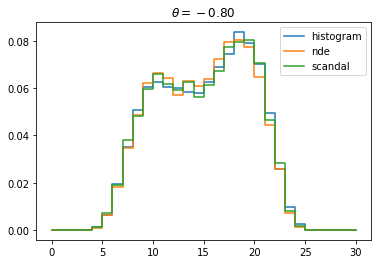

In [186]:
plt.step(range(n_nails), p_estimated_0, label="histogram")
plt.step(range(n_nails), nde.predict([theta_0]).ravel(), label="nde")
plt.step(range(n_nails), scandal.predict([np.array([[theta_0]]), np.zeros((1, n_nails))])[0][0], label="scandal")
plt.legend()
plt.title(r"$\theta=%.2f$" % theta_0)
plt.show()

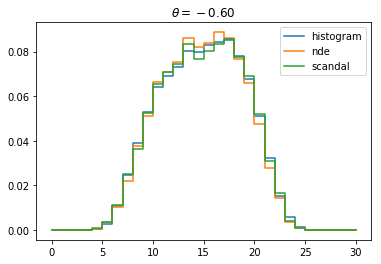

In [187]:
plt.step(range(n_nails), p_estimated_1, label="histogram")
plt.step(range(n_nails), nde.predict([theta_1]).ravel(), label="nde")
plt.step(range(n_nails), scandal.predict([np.array([[theta_1]]), np.zeros((1, n_nails))])[0][0], label="scandal")
plt.legend()
plt.title(r"$\theta=%.2f$" % theta_1)
plt.show()

# CARL

# ROLR + RASCAL

---

# Model comparison